In [185]:
import galarp as grp
grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from gala.units import galactic

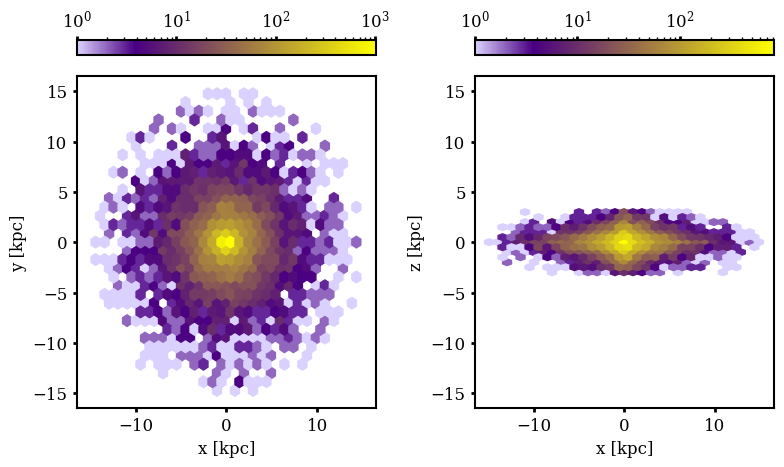

In [18]:
jz2023_satellite = grp.builtins.JZ2023_Satellite()
mass_profile = grp.gen_mass_profile(jz2023_satellite)

particles = grp.ExponentialGrid(h_R=jz2023_satellite["gas"].parameters["a"],
                                h_z=jz2023_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")

particles.plot_density(cmap=cmap, gridsize=30)

particles = grp.UniformGrid(n_particles=50)
particles.generate(mass_profile=mass_profile)

In [124]:
particles = grp.UniformGrid(n_particles=150)
particles.generate(mass_profile=mass_profile)

In [157]:
inc = 45
wind = grp.StepFunctionWind(t0=200 * u.Myr, units=galactic)
wind.init_from_inc(inclination=np.deg2rad(inc), strength= 1200 * u.km/u.s)

shadow = grp.UniformShadow(damping=0.4, R_disk=3*jz2023_satellite["gas"].parameters["a"],
                           zmin=0.5 * u.kpc)
shadow.init_from_wind(wind)



In [158]:
sim = grp.RPSim(wind=wind, potential=jz2023_satellite, shadow=shadow)
orbits = sim.run(particles, rho_icm=1e-27 * u.g/u.cm**3, integration_time=2000 * u.Myr, dt=5*u.Myr)

--------------------------------------------------------------------------------
------ Running GALA sim with  1.23e+00 kpc / Myr  wind at  0.79  degrees -------
------- Running for 2000.0 Myr  at a timestep of  5.0 Myr  (400.0 steps) -------
--------------------------------------------------------------------------------
---------------------- Container contains 17420 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------


100%|██████████| 399/399 [00:09<00:00, 41.71it/s]


In [159]:
grp.k3d_plot([orbits], outname="temp/orbits.html", duration=60)

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_17565/2259808274.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


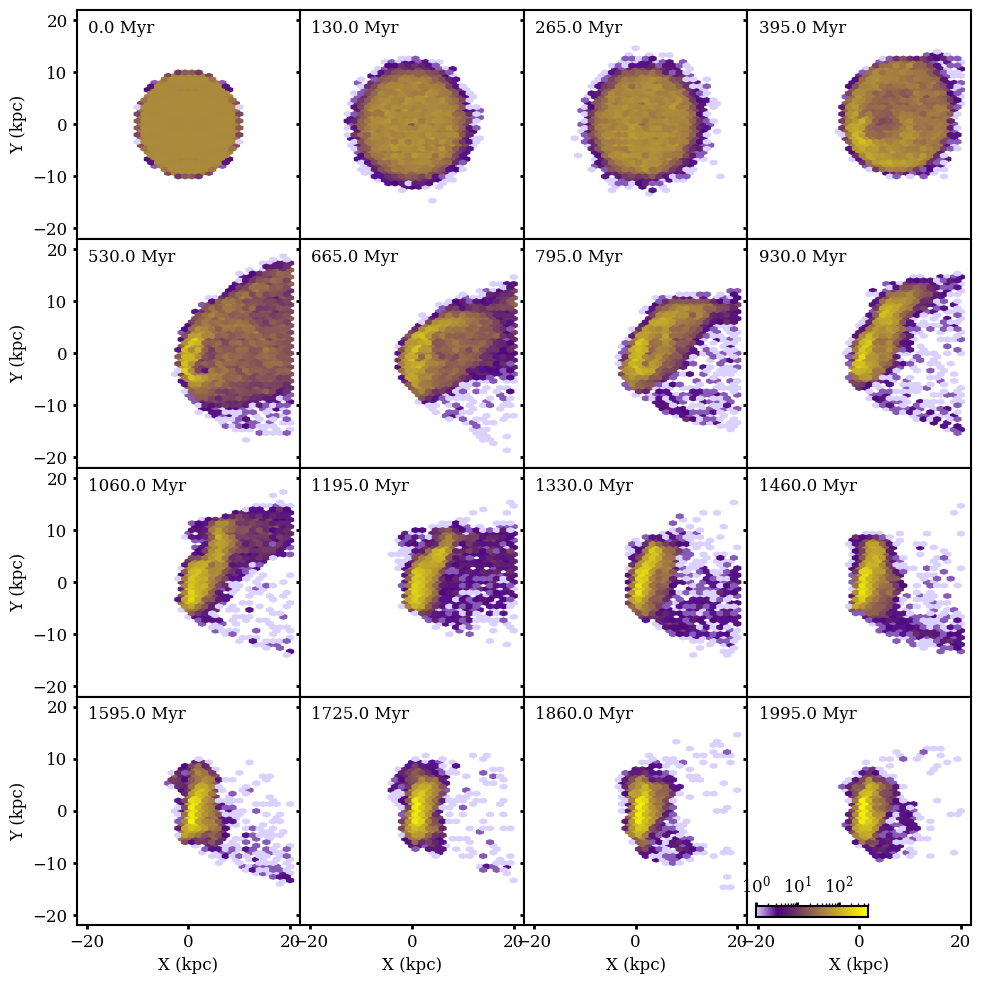

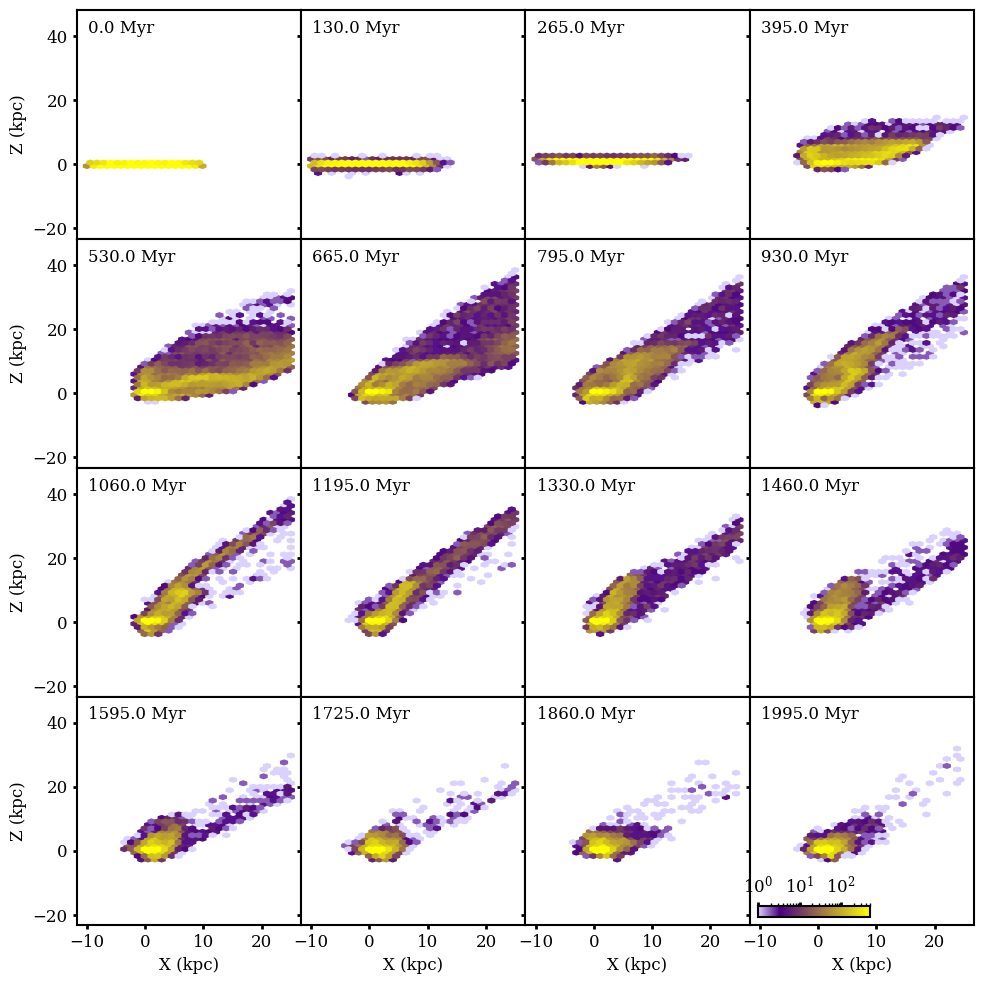

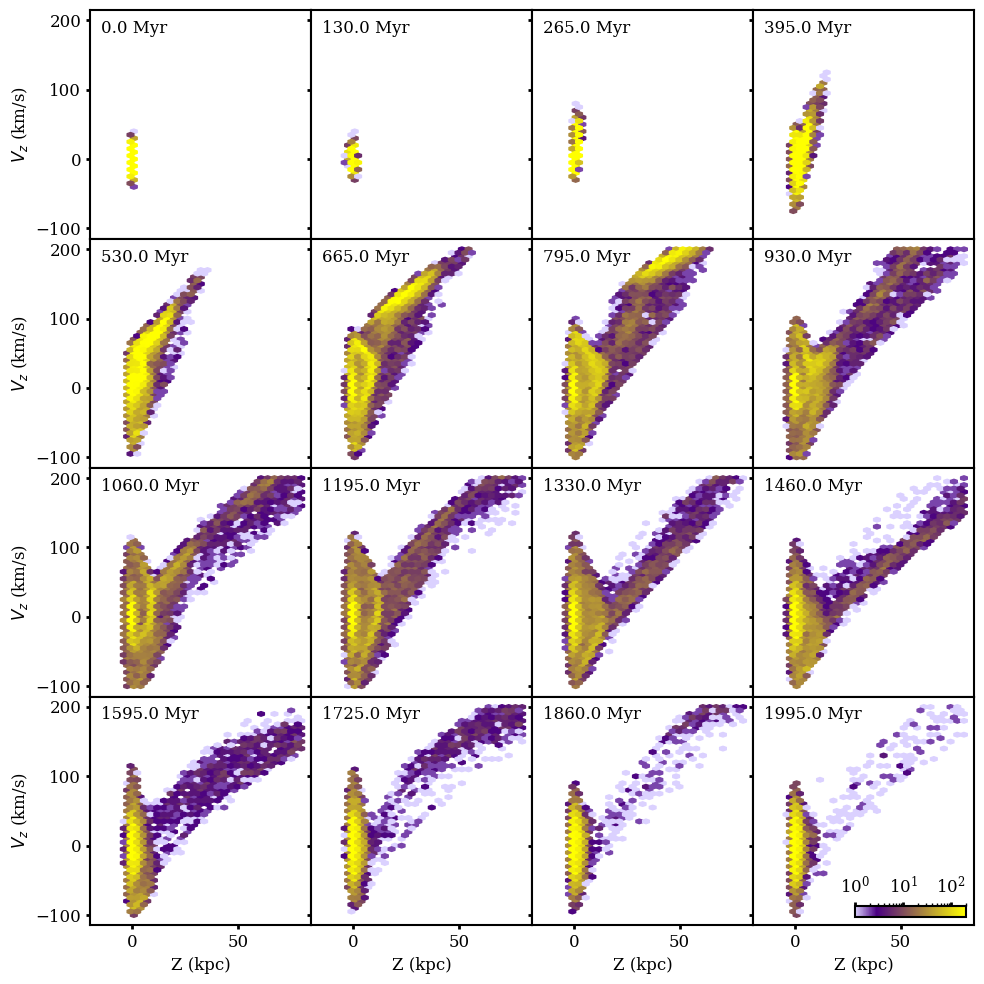

In [231]:
class MatrixPlot:
    def __init__(self, **kwargs):
        self.cmap = kwargs.get("cmap", "viridis")
        self.figsize = kwargs.get("figsize", (10, 10))
        self.nrows = kwargs.get("nrows", 4)
        self.ncols = kwargs.get("ncols", 4)

        self.sharex = kwargs.get("sharex", True)
        self.sharey = kwargs.get("sharey", True)

    def create(self):
        self.fig, self.ax = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize, 
                               sharex=self.sharex, sharey=self.sharey)
        return self.fig, self.ax
    
    def populate(self, method, *args):
        index = 0
        for i in range(self.nrows):
            for j in range(self.ncols):
                method(i, j, index, *args)
                index += 1
    
    def add_xy_labels(self, xlabel, ylabel):
        for i in range(self.nrows):
            self.ax[i, 0].set_ylabel(ylabel)
        for j in range(self.ncols):
            self.ax[self.nrows - 1, j].set_xlabel(xlabel)
    
    def add_colorbar(self,i,j, mappable, loc="lower left"):
        ia = inset_axes(self.ax[i,j], width="50%", height="5%", loc=loc)
        plt.colorbar(mappable=mappable, cax=ia, orientation="horizontal")
        ia.xaxis.set_ticks_position("top")


def density_xy_matrix(orbits, x_ind=0, y_ind=1, nrows=4, ncols=4, outname=None, **kwargs):
    times = kwargs.get("times", np.linspace(0, len(orbits.data.t) - 1, nrows * ncols).astype(int))
    xextent = kwargs.get("xextent", (-40., 40.))
    xextent = (-xextent, xextent) if isinstance(xextent, (int, float)) else xextent
    yextent = kwargs.get("yextent", (-40., 40.))
    yextent = (-yextent, yextent) if isinstance(yextent, (int, float)) else yextent

    cbar_loc = kwargs.get("cbar_loc", "lower left")

    vmin, vmax = kwargs.get("vmin", 1), kwargs.get("vmax", 500)

    gridsize = kwargs.get("gridsize", 30)

    xlabel=kwargs.get("xlabel", "X (kpc)")
    ylabel=kwargs.get("ylabel", "Y (kpc)")
    
    mplot = MatrixPlot(**kwargs)
    fig, ax = mplot.create()

    data = grp.get_orbit_data(orbits.data)

    x, y = data[x_ind], data[y_ind]

    mappables = []
    index = 0
    def method(i, j, index, x, y):
        this_x, this_y = x.T[times[index]], y.T[times[index]]

        hb = ax[i, j].hexbin(this_x, this_y, bins="log", cmap=mplot.cmap, gridsize=(gridsize, gridsize),
                        extent=[xextent[0], xextent[1], yextent[0], yextent[1]], 
                        vmin=vmin, vmax=vmax)
        mappables.append(hb)
        xmin, xmax = ax[i, j].get_xlim()
        ymin, ymax = ax[i, j].get_ylim()
        dx, dy = xmax - xmin, ymax - ymin
        
        ax[i, j].text(xmin + dx/20, ymax - dy/10, f'{orbits.data.t[times[index]]}')

    mplot.populate(method, x, y)
    mplot.add_xy_labels(xlabel, ylabel)

    mplot.add_colorbar(i=nrows-1, j=ncols-1, mappable=mappables[-1], loc=cbar_loc)


    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)

    if outname is not None:
        plt.savefig(outname)
    else:
        plt.show()


density_xy_matrix(orbits, xextent=20, yextent=20, outname="figures/density_xy_matrix.png", cmap=cmap)

density_xy_matrix(orbits, y_ind=2, ylabel = "Z (kpc)", xextent=(-10, 25), yextent=(-20, 45), 
                  outname="figures/density_xz_matrix.png", cmap=cmap)

density_xy_matrix(orbits, x_ind=2, y_ind=5, 
                  xlabel="Z (kpc)", ylabel=r"$V_z$ (km/s)",
                  xextent=(-15, 80), yextent=(-100, 200),
                  outname="figures/density_zvz_matrix.png", cmap=cmap, vmax=200,
                  cbar_loc="lower right")


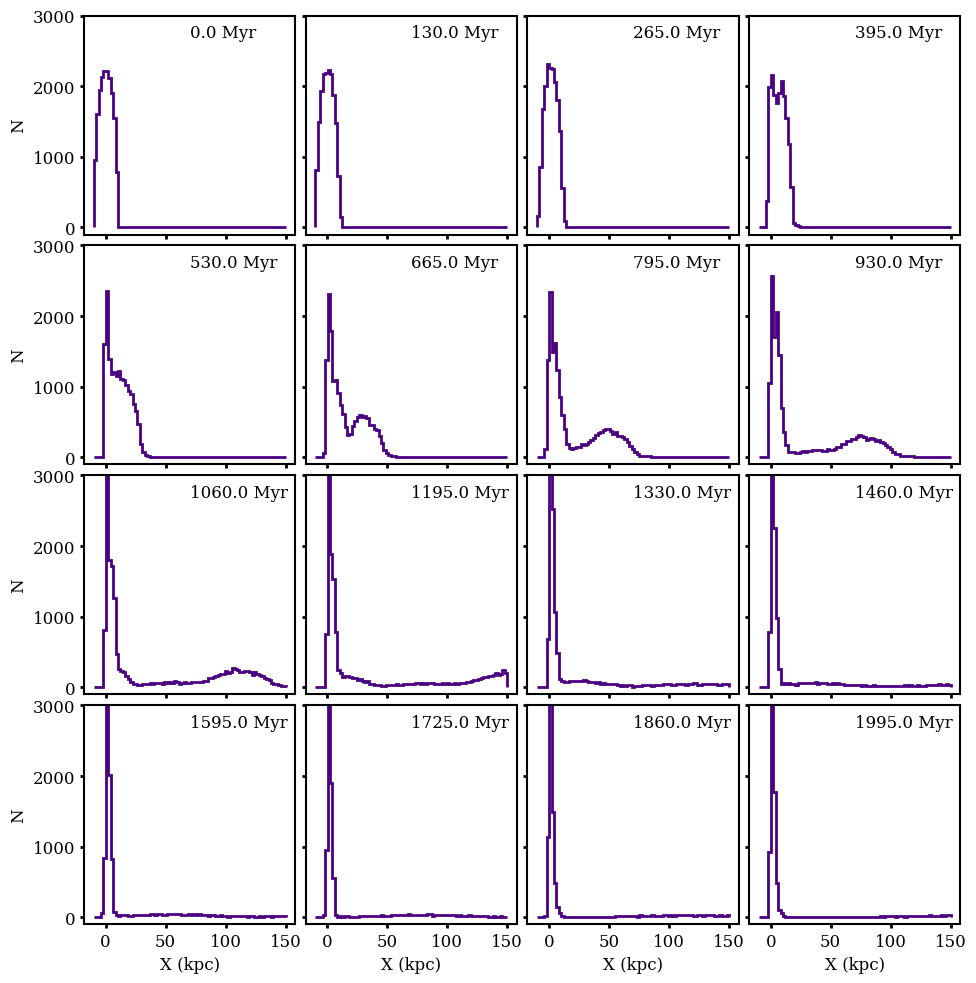

In [239]:
def hist_matrix(orbits, index=0, labels = ["x,y,z"], nrows=4, ncols=4, outname=None, **kwargs):
    times = kwargs.get("times", np.linspace(0, len(orbits.data.t) - 1, nrows * ncols).astype(int))
    xbins = kwargs.get("xbins", np.linspace(-10, 150, 80))

    xlabel=kwargs.get("xlabel", "X (kpc)")
    ylabel=kwargs.get("ylabel", "N")

    ylims = kwargs.get("ylims", (-100, 3000))

    color = kwargs.get("color", "black")
    
    mplot = MatrixPlot(sharex=True, sharey=True, **kwargs)
    fig, ax = mplot.create()

    data = grp.get_orbit_data(orbits.data)

    x = data[index]

    index = 0
    def method(i, j, index, x):
        this_x = x.T[times[index]]

        ax[i, j].hist(this_x, bins=xbins, color=color, fill=False, histtype='step', lw=2)

        ax[i, j].set_ylim(ylims)
        xmin, xmax = ax[i, j].get_xlim()
        ymin, ymax = ax[i, j].get_ylim()
        dx, dy = xmax - xmin, ymax - ymin
        
        ax[i, j].text(xmax - dx/2, ymax - dy/10, f'{orbits.data.t[times[index]]}')

    mplot.populate(method, x)
    mplot.add_xy_labels(xlabel, ylabel)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

    if outname is not None:
        plt.savefig(outname)
    else:
        plt.show()

hist_matrix(orbits, outname="figures/hist_matrix.png", color="indigo")

130.0 Myr
(400, 17420)


(array([ 128., 1075., 2134., 2730., 2873., 2937., 2617., 2038.,  816.,
          72.]),
 array([-12.97762618, -10.32663918,  -7.67565217,  -5.02466517,
         -2.37367816,   0.27730885,   2.92829585,   5.57928286,
          8.23026986,  10.88125687,  13.53224387]),
 <BarContainer object of 10 artists>)

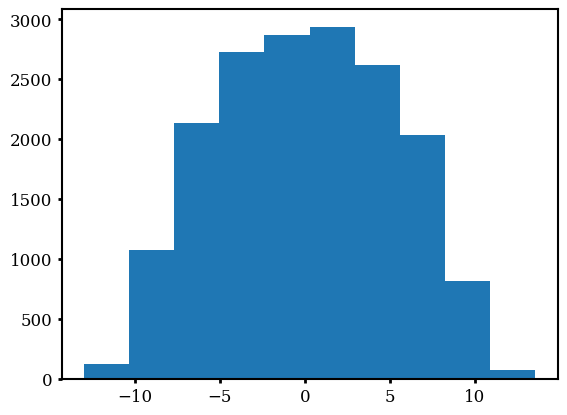

In [205]:
x,y,z, *_ = grp.get_orbit_data(orbits.data)
print(orbits.data.t[26])
print(x.T.shape)

plt.hist(x.T[26])